In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
!pip install spacy
!python -m spacy download pt_core_news_md
!pip install seaborn
!pip install fuzzywuzzy
!pip install nameparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 8.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import ast
import chardet
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import re
import requests
import seaborn as sns
import spacy
from ast import literal_eval
from collections import Counter, defaultdict
from fuzzywuzzy import process
from itertools import combinations, product
from nameparser import HumanName
from networkx.algorithms import community


#Load NLP package

nlp = spacy.load('pt_core_news_md')

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#Load data

Load Book in analysis and perform NLP

In [4]:
#Tag book with spacy

doc= open('/content/drive/MyDrive/SNA Pipeline (Tese)/Livros (1)/Amor de Perdição.txt', 'r', encoding='utf-8').read()

#NLP max lenght might need to be increased depending in lenght of the book (might affect performance)
nlp.max_length= 1500000

book = nlp(doc)


Retrieve Tags done by LX-Tagger

In [5]:
#Load book tagged by LX-Tagger

ltags = pd.read_excel('/content/drive/MyDrive/SNA Pipeline (Tese)/POS Books (1)/complete (1)/POS Amor de Perdição (1-72).xlsx')


#Name Retrieval and Information extraction

##Identify Character Names

Create a list of every candidate for sequences of names in LX-tagger and count ocurrences for future reference as well as preceding tokens for context

In [6]:
# List to store sequences
sequences = []

# Dictionary to store sequence counts
sequence_counter = {}

# Set to keep track of unique sequences
printed_sequences = set()

# Dictionary to store preceding tokens for each sequence
preceding_tokens_dict = {}

# Variable to store the last unfinished sequence
last_sequence = []

for _, row in ltags.iterrows():
    for cell in row.dropna():
        try:
            sentence = ast.literal_eval(cell)  # Convert string to list of tokens
        except ValueError as e:
            print(f"Error converting cell content to list: {e}")
            continue

        i = 0  # Initialize counter i
        while i < len(sentence):
            token = sentence[i]
            # Check if token is PNM or STT and has a form
            if token['pos'] == 'PNM' and token['form']:
                pnm_sequence = [token['form']]  # Start a new sequence with the current PNM form
                # Look back for the two preceding tokens
                j = max(i - 2, 0)
                preceding_tokens = [sentence[k]['form'] for k in range(j, i)]
                i += 1  # Move to the next token
            elif token['pos'] == 'STT' and i + 1 < len(sentence) and sentence[i + 1]['pos'] == 'PNM':
                pnm_sequence = [token['form'], sentence[i + 1]['form']]  # Start a new sequence with STT and PNM
                # Look back for the two preceding tokens
                j = max(i - 2, 0)
                preceding_tokens = [sentence[k]['form'] for k in range(j, i)]
                i += 2  # Skip the next token as it's already included
            else:
                i += 1  # Move to the next token if current is not a valid start
                continue  # Continue to the next iteration of the loop

            # Look ahead for PREP (containing "de"), DA, PNM patterns
            j = i  # Start looking ahead from the current position
            while j < len(sentence):
                if sentence[j]['pos'] == 'PREP' and "de" in sentence[j]['form'].lower():
                    if j + 1 < len(sentence) and sentence[j + 1]['pos'] == 'PNM':
                        pnm_sequence += [sentence[j]['form'], sentence[j + 1]['form']]  # Add PREP and PNM
                        j += 2  # Move past the added tokens
                    elif j + 2 < len(sentence) and sentence[j + 1]['pos'] == 'DA' and sentence[j + 2]['pos'] == 'PNM':
                        pnm_sequence += [sentence[j]['form'], sentence[j + 1]['form'], sentence[j + 2]['form']]  # Add PREP, DA, PNM
                        j += 3  # Move past the added tokens
                    else:
                        break  # Exit loop if next token is not as expected
                elif sentence[j]['pos'] == 'PNM' and sentence[j]['form']:
                    pnm_sequence.append(sentence[j]['form'])  # Add another PNM
                    j += 1  # Move to the next token
                else:
                    break  # Exit loop if next token is not PNM or the correct sequence

            # Check if a valid sequence was found and it's not just a single STT token
            if len(pnm_sequence) > 1 or (len(pnm_sequence) == 1 and pnm_sequence[0] != 'STT'):
                # Check if the last token processed in the current row is the last token before changing to the next row
                if i == len(sentence):
                    last_sequence = pnm_sequence  # Store the unfinished sequence for the next row
                else:
                    # If there is an unfinished sequence from the previous row, add it to the current sequence
                    if last_sequence:
                        pnm_sequence = last_sequence + pnm_sequence
                        last_sequence = []  # Reset the last_sequence variable
                    sequence_str = " ".join(pnm_sequence)
                    if sequence_str not in printed_sequences:
                        sequences.append(sequence_str)
                        printed_sequences.add(sequence_str)
                    sequence_counter[sequence_str] = sequence_counter.get(sequence_str, 0) + 1  # Increment count or initialize if new
                    # Store preceding tokens for the current sequence
                    preceding_tokens_dict.setdefault(sequence_str, []).append(preceding_tokens)
            i = j  # Update the outer loop counter to resume from where the inner loop left off

# Remove all occurrences of "…" from sequences list
sequences = [sequence.replace("…", "") for sequence in sequences]

# Sort sequence_counter in descending order based on counts
sorted_sequence_counter = {k: v for k, v in sorted(sequence_counter.items(), key=lambda item: item[1], reverse=True)}


In [7]:
sorted_sequence_counter

{'Simão': 285,
 'Teresa': 216,
 'Mariana': 161,
 'Deus': 62,
 'Simão Botelho': 61,
 'Vossa Senhoria': 60,
 'Viseu': 58,
 'João de_ a Cruz': 52,
 'Baltasar': 51,
 'Coimbra': 39,
 'Porto': 38,
 'João': 30,
 'Domingos Botelho': 25,
 'Lisboa': 23,
 'Manuel': 22,
 'Tadeu de Albuquerque': 22,
 'Albuquerque': 22,
 'D. Rita': 20,
 'Baltasar Coutinho': 19,
 'Castro Daire': 19,
 'Vila Real': 16,
 'égua': 15,
 'Monchique': 15,
 'Às': 14,
 'Rita': 11,
 'Tadeu': 11,
 'Constança': 10,
 'Joaquina': 9,
 'Índia': 9,
 'D. Rita Preciosa': 8,
 'Manuel Botelho': 8,
 'Senhor': 7,
 'Portugal': 6,
 'Espanha': 6,
 'Lamego': 5,
 'Nossa Senhora': 5,
 'D. Teresa': 5,
 'Vossa Excelência': 5,
 'Josefa': 5,
 'Cascais': 4,
 'Fernão Botelho': 4,
 'Senhora': 4,
 'Relação': 4,
 'ó': 4,
 'Mourão Mosqueira': 4,
 'Mosqueira': 4,
 'Meneses': 3,
 'D. Maria I': 3,
 'Conta': 3,
 'França': 3,
 'ódio': 3,
 'Tanta': 3,
 'Cuida': 3,
 'Mestre João': 3,
 'Pudera': 3,
 'Passos': 3,
 'Sua': 3,
 'Botelho': 3,
 'Montezelos': 3,
 'Fale':

Identify all sequences that are confirmed to be names by proceding a oficial title, add them to a final list and remove them from current working list

In [8]:
# List of portuguese Titles
titles = {"dr", "d.r", "dr.", "dra.", "dra", "senhor", "senhora", "d.ra", "sr", "sr.", "sra", "sra.", "prof", "prof.", "profa", "eng.", "eng", "d", "d.", "v.", "ex.", "ex.a", "s.ª", "ex.ª", "dom", "d.ª", "da.", "il.mo", "ilmo.", "ilmo", "il.ma", "ilma.", "ilma", "rev"}

matching_sequences = set()  # To store sequences excluding the initial title or STT tag

# Part 1: Handling Titles and STT Tags
# Create a copy of the original sequences list to avoid modifying it while iterating
sequences_copy = sequences.copy()

for sequence in sequences_copy:
    words = sequence.split()
    if not words:
        continue  # Skip empty sequences

    first_word = words[0].lower()  # Lowercase for case-insensitive comparison
    is_title = first_word in titles
    is_stt = first_word == "[stt]"

    if is_title or is_stt:
        title_or_stt = words[0]  # The original title or STT tag
        rest_of_sequence = words[1:]  # Sequence excluding the title or STT tag
        # Check if the next word (if exists) also belongs to titles or is an "STT" tag
        if rest_of_sequence and (rest_of_sequence[0].lower() in titles or rest_of_sequence[0].lower() == "[stt]"):
            print(f"Excluded: {title_or_stt}, {rest_of_sequence[0]}")  # For visibility
            # Exclude the first two words if the second word also belongs to titles or is an "STT" tag
            rest_of_sequence = rest_of_sequence[1:]  # Exclude the second word
        print(f"Excluded: {title_or_stt}, {' '.join(rest_of_sequence)}")  # For visibility
        if rest_of_sequence:
            matching_sequences.add(" ".join(rest_of_sequence))  # Add to matching_sequences if not empty
            sequences.remove(sequence)  # Remove the sequence from the original list

# Update 'sequences' to exclude processed sequences
sequences = [seq for seq in sequences if seq not in matching_sequences]


Excluded: D., Rita Teresa Margarida Preciosa de_ a Veiga Caldeirão Castelo Branco
Excluded: D., Maria I
Excluded: D., Rita Preciosa
Excluded: D., Rita
Excluded: D., Dinis
Excluded: Senhora, 
Excluded: Senhora, de Almudena
Excluded: D., Maria I.
Excluded: Senhor, 
Excluded: D., Teresa
Excluded: Senhora, de_ os Remédios
Excluded: D., Ritinha
Excluded: Senhor, João
Excluded: D., Teresinha Albuquerque
Excluded: Senhor, Simão
Excluded: D., Rita Teresa Margarida Preciosa Caldeirão Castelo Branco
Excluded: D., Teresa Clementina de Albuquerque
Excluded: D., Teresinha de Viseu
Excluded: D., Ana Amália
Excluded: senhor, 
Excluded: D., Rita Emília de_ a Veiga Castelo Branco


In [9]:
# List of phrases indicating a person in preceding tokens
indicators = [
    "amigo de", "conhecido de", "colega de", "cônjuge de", "disse", "dizia", "diz", "inquiria", "debateu", "dialogou",
    "discutiu", "disse-me", "gritava", "gritou", "perguntou", "suspirou", "suspirava", "reclamou", "reclamava",
    "esposa de", "viúva", "viúvo", "familiar de", "falou", "filha de", "filho de", "irmã de", "irmão de",
    "marido de", "mãe de", "namorado de","tio","tia", "neto de", "opinião de", "palavras de", "pai de", "parente de",
    "perguntar a", "perguntou a", "prima de", "primo de", "respondeu", "retorquiu", "sussurrou", "vizinho de",
    "os filhos de", "as filhas de", "tenente", "soldado", "alferes", "major", "general", "comandante", "capitão",
    "capitã", "barão", "baronesa", "detetive", "inspetor", "professor", "professora", "doutor", "doutora",
    "mestre", "mestra", "padre", "madre", "reverendo", "cónego","bispo", "chamava-se", "se chamava", "se chamar","a srª","o srº"
]

# Cross-reference sequences in cleaned_sequences with the preceding_tokens_dict
for sequence in sequences:
    if sequence in preceding_tokens_dict:
        preceding_tokens = preceding_tokens_dict[sequence]
        for tokens in preceding_tokens:
            # Join tokens with space to form the preceding text
            preceding_text = " ".join(tokens)

            # Split the preceding text into individual tokens
            preceding_token_list = preceding_text.split()

            # Token matching
            token_matching_phrases = []
            for phrase in indicators:
                phrase_tokens = phrase.split()
                for i in range(len(preceding_token_list) - len(phrase_tokens) + 1):
                    if preceding_token_list[i:i + len(phrase_tokens)] == phrase_tokens:
                        token_matching_phrases.append(phrase)
                        break

            if token_matching_phrases:
                # Add the sequence to 'matching_sequences' set
                matching_sequences.add(sequence)
                try:
                    sequences.remove(sequence)
                except ValueError:
                    pass  # Sequence not found in 'sequences', ignore

                # Print the matching sequence and preceding tokens
                print(f"Sequence: {sequence}")
                print(f"Matching Preceding Tokens: {preceding_text}")
                print(f"Matching Phrases: {', '.join(token_matching_phrases)}")
                break  # Move to the next sequence

# Print the remaining sequences in 'sequences'
print("\nRemaining Sequences:")
for sequence in sequences:
    print(sequence)

Sequence: Domingos Botelho
Matching Preceding Tokens: amigo de
Matching Phrases: amigo de
Sequence: Coimbra
Matching Preceding Tokens: tio de
Matching Phrases: tio
Sequence: Sebastião José de Carvalho
Matching Preceding Tokens: filho de
Matching Phrases: filho de
Sequence: Manuel
Matching Preceding Tokens: — disse
Matching Phrases: disse
Sequence: Caldeirão
Matching Preceding Tokens: o general
Matching Phrases: general
Sequence: Tadeu de Albuquerque
Matching Preceding Tokens: filha de
Matching Phrases: filha de
Sequence: Baltasar Coutinho
Matching Preceding Tokens: — disse
Matching Phrases: disse
Sequence: Baltasar
Matching Preceding Tokens: — disse
Matching Phrases: disse
Sequence: Mariana
Matching Preceding Tokens: disse a
Matching Phrases: disse
Sequence: João de_ a Cruz
Matching Preceding Tokens: mestre ferrador
Matching Phrases: mestre
Sequence: Vossa Senhoria
Matching Preceding Tokens: pai de
Matching Phrases: pai de
Sequence: Monchique
Matching Preceding Tokens: tia de
Matching 

Keep treating remaining working list

Re-tag sequences using spacy

In [10]:
# Create an empty list to store tagged sequences
tagged_sequences = []

# Iterate over each phrase in sequences
for phrase in sequences:
    # Split the phrase into words
    words = phrase.split()

    # Create an empty list to store tagged words
    tagged_words = []

    # Process each word individually
    for word in words:
        # Apply spaCy processing to each word
        word_lis = nlp(word)

        # Store the word and its tag in a tuple
        tagged_word = [(token.text, token.tag_) for token in word_lis]

        # Append the tagged word to the list of tagged words
        tagged_words.extend(tagged_word)

    # Append the tagged words to the list of tagged sequences
    tagged_sequences.append(tagged_words)

# Now, tagged_sequences contains the sequences of words with their corresponding tags
# Iterate over each tagged sequence
for tagged_sequence in tagged_sequences:
    # Print each word along with its tag
    for word, tag in tagged_sequence:
        print(f"Word: {word}, Tag: {tag}")

    # Print a newline to separate each sequence
    print()


Word: I, Tag: PROPN
Word: Domingos, Tag: PROPN
Word: José, Tag: PROPN
Word: Correia, Tag: PROPN
Word: Botelho, Tag: PROPN
Word: de, Tag: ADP
Word: Mesquita, Tag: PROPN

Word: Meneses, Tag: NOUN

Word: Vila, Tag: PROPN
Word: Real, Tag: NOUN
Word: de, Tag: ADP
Word: Trás-os-Montes, Tag: NOUN

Word: Cascais, Tag: PROPN

Word: António, Tag: PROPN
Word: de, Tag: ADP
Word: Azevedo, Tag: PROPN
Word: Castelo, Tag: NOUN
Word: Branco, Tag: NOUN
Word: Pereira, Tag: PROPN
Word: de, Tag: ADP
Word: _, Tag: NOUN
Word: a, Tag: ADP
Word: Silva, Tag: PROPN

Word: Arte, Tag: NOUN
Word: de, Tag: ADP
Word: _, Tag: NOUN
Word: a, Tag: ADP
Word: Guerra, Tag: NOUN

Word: Lisboa, Tag: PROPN

Word: Douro, Tag: PROPN

Word: Vila, Tag: PROPN
Word: Real, Tag: NOUN

Word: Fernão, Tag: PROPN
Word: Botelho, Tag: PROPN

Word: Aveiro, Tag: NOUN

Word: Junqueira, Tag: PROPN

Word: Oeiras, Tag: PROPN

Word: Pintos, Tag: NOUN
Word: Coelhos, Tag: PROPN
Word: de, Tag: ADP
Word: _, Tag: NOUN
Word: o, Tag: DET
Word: Bonjardim,

Exclude starting words in sequences that were mistankenly tagged as Proper Names Until one is found or remove sequence

In [11]:

# Create empty lists to store filtered sequences and removed words for each sequence
filtered_sequences = []
removed_words_per_sequence = []

# Iterate over each tagged sequence
for tagged_sequence in tagged_sequences:
    # Iterate through each word and its tag in the sequence
    for idx, (word, tag) in enumerate(tagged_sequence):
        # If the word is tagged as a proper noun (PROPN)
        if tag == 'PROPN':
            # Keep the sequence starting from this word
            filtered_sequence = tagged_sequence[idx:]
            filtered_sequences.append(filtered_sequence)
            # Store the removed words before the proper noun
            removed_words = [w for w, _ in tagged_sequence[:idx]]
            removed_words_per_sequence.append(removed_words)
            break
    else:
        # If no proper noun is found in the sequence, add the whole sequence to removed_sequences
        removed_words_per_sequence.append([w for w, _ in tagged_sequence])

# Now, filtered_sequences contains the sequences starting from the first proper noun,
# and removed_words_per_sequence contains the removed words for each sequences
removed_words_per_sequence

[[],
 ['Meneses'],
 [],
 [],
 [],
 ['Arte', 'de', '_', 'a', 'Guerra'],
 [],
 [],
 [],
 [],
 ['Aveiro'],
 [],
 [],
 ['Pintos'],
 [],
 [],
 [],
 ['Caldeirões'],
 [],
 [],
 ['Ajuda'],
 ['Correias', 'de'],
 ['Cuidei'],
 [],
 [],
 [],
 [],
 ['Inverno'],
 [],
 [],
 ['Vulcano'],
 [],
 [],
 [],
 [],
 [],
 ['Almacave'],
 [],
 [],
 [],
 ['Conta'],
 [],
 ['Trás-os-Montes'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Amava'],
 [],
 ['Espanta'],
 ['índole', 'de'],
 [],
 [],
 [],
 [],
 [],
 ['ódio'],
 ['Tanta'],
 ['Olé'],
 ['Albuquerque'],
 [],
 [],
 [],
 ['Acaso'],
 ['Lucro'],
 [],
 ['ter'],
 ['Casada'],
 [],
 ['ínfima'],
 ['IV'],
 ['Hás'],
 ['Tremia'],
 ['índole'],
 [],
 ['vê-la'],
 [],
 ['Às'],
 [],
 ['Moças'],
 ['Replicava'],
 [],
 ['Notou'],
 [],
 ['jaqueta'],
 ['égua'],
 ['Carção'],
 ['Nossa'],
 [],
 [],
 [],
 ['Vossa', 'Senhoria'],
 ['Cuida'],
 ['Mestre'],
 ['Mas'],
 ['forca'],
 ['diabos'],
 ['Faça'],
 ['ângulo'],
 ['n

Get remaining sequences in string format

In [12]:
# Extract words from filtered sequences without tags
filtered_sequences_without_tags = [[word for word, _ in sequence] for sequence in filtered_sequences]

# Print the filtered sequences without tags
for sequence in filtered_sequences_without_tags:
    print(' '.join(sequence))

# Make filtered_sequences_without_tags the main list to work from
sequences_to_work_from = filtered_sequences_without_tags

# Convert each inner list into a string
names_list = [' '.join(sequence) for sequence in sequences_to_work_from]

# Print the sequences as strings
for sequence in names_list:
    print(sequence)


I Domingos José Correia Botelho de Mesquita
Vila Real de Trás-os-Montes
Cascais
António de Azevedo Castelo Branco Pereira de _ a Silva
Lisboa
Douro
Vila Real
Fernão Botelho
Junqueira
Oeiras
Coelhos de _ o Bonjardim de _ o Porto
Pedro
Luís de Camões
Bernardim Ribeiro
Maria
Ana
Mesquita
Senhora
Mafra
Sintra
Queluz
Marialva
Vénus
Júpiter
Luís Botelho
Digesto
Reino
Lamego
Botelhos Correias de Mesquita
Domingos José Correia Botelho de Mesquita
Viseu
Paulo Botelho Correia
Bragança Manuel Botelho
Simão Botelho
Portugal
Inglaterra
França
António de Araújo de Azevedo
Barca
Madrid
Paris
Espanha
Lafões
Luís Pinto de Sousa
Balsemão
Badajoz
Olivença
Napoleão
Danton
Robespierre
Desmoulins
Hércules
Saint-Just
Viseu Simão
Estio
Simão
Teresa de Albuquerque
Simão Botelho
Descera
Manuel Botelho
Bragança
Porto
Deus
Tadeu
Castro Daire
Verdade
Desobedeceria
Coimbra Baltasar Coutinho
Teresa
Feliz
Enlevo
V Baltasar Coutinho
Teresa
Velou Teresa
Simão
Pr
Senhora
Senhor
Maria Santíssima
Decerto
João de _ a Cruz


Import Cities and countries names (more countries can be added)

In [13]:
cities = pd.read_excel('/content/drive/MyDrive/SNA Pipeline/Geo Places PT/worldcities.xlsx')
cities = cities[cities['country'].isin(['Portugal', 'Spain', 'Brasil','France'])]

Remove entries that are exclusevly city names (doenst affect names that have a name of a city)

In [14]:
filtered_sequences = []  # To store sequences after applying both filters
removed_words_combined = []  # To store words removed due to being city names or before the first PROPN

# Iterate over each tagged sequence
for tagged_sequence in tagged_sequences:
    sequence_modified = []  # Temporarily stores the sequence after modification
    removed_words_temp = []  # Temporarily stores removed words for this sequence
    proper_noun_found = False  # Flag to indicate the first PROPN not a city is found

    for idx, (word, tag) in enumerate(tagged_sequence):
        # Skip proper nouns that are city names before finding the first significant PROPN
        if tag == 'PROPN' and not proper_noun_found:
            if word in list(cities['city']):
                removed_words_temp.append(word)
                continue
            else:
                proper_noun_found = True  # Mark that we've found our starting PROPN

        # After finding the first significant PROPN, add all words to the sequence
        if proper_noun_found:
            sequence_modified.append((word, tag))
        else:
            # If no proper noun has been found yet, add words to removed list
            removed_words_temp.append(word)

    # If a proper noun that is not a city name has been found, store the modified sequence
    if proper_noun_found:
        filtered_sequences.append(sequence_modified)
    # Always store the removed words
    removed_words_combined.append(removed_words_temp)
removed_words_combined

[[],
 ['Meneses'],
 [],
 ['Cascais'],
 [],
 ['Arte', 'de', '_', 'a', 'Guerra'],
 ['Lisboa'],
 [],
 [],
 [],
 ['Aveiro'],
 [],
 ['Oeiras'],
 ['Pintos'],
 [],
 [],
 [],
 ['Caldeirões'],
 [],
 [],
 ['Ajuda'],
 ['Correias', 'de'],
 ['Cuidei'],
 [],
 ['Mafra'],
 ['Sintra'],
 ['Queluz'],
 ['Inverno'],
 [],
 [],
 ['Vulcano'],
 [],
 [],
 [],
 [],
 ['Lamego'],
 ['Almacave'],
 [],
 [],
 ['Viseu'],
 ['Conta'],
 [],
 ['Trás-os-Montes'],
 ['Bragança'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Madrid'],
 ['Paris'],
 [],
 [],
 [],
 [],
 ['Badajoz'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Viseu'],
 [],
 ['Amava'],
 [],
 ['Espanta'],
 ['índole', 'de'],
 [],
 [],
 ['Bragança'],
 ['Porto'],
 [],
 ['ódio'],
 ['Tanta'],
 ['Olé'],
 ['Albuquerque'],
 [],
 [],
 [],
 ['Acaso'],
 ['Lucro'],
 [],
 ['ter'],
 ['Casada'],
 ['Coimbra'],
 ['ínfima'],
 ['IV'],
 ['Hás'],
 ['Tremia'],
 ['índole'],
 [],
 ['vê-la'],
 [],
 ['Às'],
 [],
 ['Moças'],
 ['Replicava'],
 [],
 ['Notou'],
 [],
 ['jaqueta'],
 ['égua'],
 ['Carção'],
 ['Nossa'

Get current working list

In [15]:
# Extract words from filtered sequences without tags
filtered_sequences_without_tags = [[word for word, _ in sequence] for sequence in filtered_sequences if sequence]

# Convert each inner list into a string, ensuring it only works with non-empty sequences
names_list = [' '.join(sequence) for sequence in filtered_sequences_without_tags]

# Print the sequences as strings, skipping empty ones
for sequence in names_list:
    if sequence:  # This checks if the sequence string is not empty
        print(sequence)

I Domingos José Correia Botelho de Mesquita
Vila Real de Trás-os-Montes
António de Azevedo Castelo Branco Pereira de _ a Silva
Douro
Vila Real
Fernão Botelho
Junqueira
Coelhos de _ o Bonjardim de _ o Porto
Pedro
Luís de Camões
Bernardim Ribeiro
Maria
Ana
Mesquita
Senhora
Marialva
Vénus
Júpiter
Luís Botelho
Digesto
Reino
Botelhos Correias de Mesquita
Domingos José Correia Botelho de Mesquita
Paulo Botelho Correia
Manuel Botelho
Simão Botelho
Portugal
Inglaterra
França
António de Araújo de Azevedo
Barca
Espanha
Lafões
Luís Pinto de Sousa
Balsemão
Olivença
Napoleão
Danton
Robespierre
Desmoulins
Hércules
Saint-Just
Simão
Estio
Simão
Teresa de Albuquerque
Simão Botelho
Descera
Manuel Botelho
Deus
Tadeu
Castro Daire
Verdade
Desobedeceria
Baltasar Coutinho
Teresa
Feliz
Enlevo
V Baltasar Coutinho
Teresa
Velou Teresa
Simão
Pr
Senhora
Senhor
Maria Santíssima
Decerto
João de _ a Cruz
Aperra
João
Arriba
Alma
Petisca
Simão Botelho
Simão Botelho
Virgem
Teresinha
Freira
Dionísia de _ a Imaculada Conc

Proces to remove words that have been incorrectly agregated with names by finding lower case versions in text

In [16]:
def clean_sequences(sequences, document_text, spacy_model):
    # Process the document text with the spacy model
    doc = spacy_model(document_text)

    # Set to store lowercase words from the document
    lowercase_words = {token.text.lower() for token in doc if token.text.islower()}

    cleaned_sequences = []  # List to store cleaned sequences

    # Iterate through each sequence in the list
    for sequence in sequences:
        # Split the sequence into words
        words = sequence.split()

        # Check if the first word in the sequence, when converted to lowercase, exists in the document
        if words[0].lower() in lowercase_words:
            # Remove the first word from the sequence if it exists in lowercase_words
            cleaned_words = words[1:]
            cleaned_sequence = " ".join(cleaned_words)
        else:
            cleaned_sequence = sequence

        # Check if the cleaned sequence is not empty after stripping whitespace
        if cleaned_sequence.strip():
            cleaned_sequences.append(cleaned_sequence)

    return cleaned_sequences

    # Call the modified function
cleaned_sequences = clean_sequences(names_list, book, nlp)

# Print the cleaned sequences
for sequence in cleaned_sequences:
    print(sequence)

I Domingos José Correia Botelho de Mesquita
Real de Trás-os-Montes
António de Azevedo Castelo Branco Pereira de _ a Silva
Douro
Real
Fernão Botelho
Junqueira
Coelhos de _ o Bonjardim de _ o Porto
Pedro
Luís de Camões
Bernardim Ribeiro
Maria
Ana
Mesquita
Marialva
Vénus
Júpiter
Luís Botelho
Digesto
Botelhos Correias de Mesquita
Domingos José Correia Botelho de Mesquita
Paulo Botelho Correia
Manuel Botelho
Simão Botelho
Portugal
Inglaterra
França
António de Araújo de Azevedo
Barca
Espanha
Lafões
Luís Pinto de Sousa
Balsemão
Olivença
Napoleão
Danton
Robespierre
Desmoulins
Hércules
Saint-Just
Simão
Estio
Simão
Teresa de Albuquerque
Simão Botelho
Descera
Manuel Botelho
Deus
Tadeu
Castro Daire
Desobedeceria
Baltasar Coutinho
Teresa
Enlevo
V Baltasar Coutinho
Teresa
Velou Teresa
Simão
Pr
Maria Santíssima
João de _ a Cruz
Aperra
João
Arriba
Petisca
Simão Botelho
Simão Botelho
Virgem
Teresinha
Dionísia de _ a Imaculada Conceição
Nini
Dionísia
Padre-Nosso
Ave-Maria
Balzac
Veneza
Japão
João de _ a

Lastly verify sequences by crossing them with a data base of Portuguese names

In [17]:

# Define file paths
file_path_txt = '/content/drive/MyDrive/SNA Pipeline/Names/names_final.txt'
file_paths_csv = [
    '/content/drive/MyDrive/SNA Pipeline/Names/nomes-registados-2016.csv',
    '/content/drive/MyDrive/SNA Pipeline/Names/nomes-registados-2015.csv'
]

# Process the text file
unique_names = set()
with open(file_path_txt, 'r') as file:
    unique_names.update(name.strip().capitalize() for name in file if name.strip())

# Function to read a CSV file and return the first column as a set
def read_csv_first_column(file_path):
    df = pd.read_csv(file_path, header=None, encoding='utf-8', usecols=[0])
    return set(df.iloc[:, 0].str.capitalize().str.strip())

# Process CSV files and update the unique names set
for file_path in file_paths_csv:
    unique_names.update(read_csv_first_column(file_path))

# Convert the set to a sorted list
sorted_unique_names = sorted(unique_names)


Join treated Names with the Names aquired in the first step, create a list of the sequences that were not confirmed as names for possible future work

In [18]:
non_matching_sequences = []

for sequence in cleaned_sequences:
    if sequence:  # Ensure the sequence is not empty
        first_word = sequence.split()[0]  # Extract the first word
        # Check if the first word matches any name in unique_names
        if first_word in unique_names:
            matching_sequences.add(sequence)
        else:
            non_matching_sequences.append(sequence)

# Print the matching sequences
print("Matching Sequences:")
for matched_sequence in matching_sequences:
    print(matched_sequence)

# Print the non-matching sequences
print("\nNon-Matching Sequences:")
for non_matched_sequence in non_matching_sequences:
    print(non_matched_sequence)


Matching Sequences:
Luís de Camões
António de Azevedo Castelo Branco Pereira de _ a Silva
Maria I.
India
Mariana
Caldeirão
Jesus Cristo
Rita
Tadeu
Tadeu de Albuquerque
Simão Botelho Castelo Branco
de Almudena
Simão
Teresa de Albuquerque
Rita Emília de_ a Veiga Castelo Branco
Rita Teresa Margarida Preciosa de_ a Veiga Caldeirão Castelo Branco
Ana Amália
Anselmo
Vossa Senhoria
Ana
Dinis
Teresa Clementina de Albuquerque
Amaro Lampreia
Josefa Maria
Manuel
João
Joaquina
Real
Luís Pinto de Sousa
Sebastião José de Carvalho
Real de Trás-os-Montes
Dionísia
Maria
Rita Teresa Margarida Preciosa Caldeirão Castelo Branco
Baltasar
Teresa Clementina
Hércules
Joaquim
Maria I
Fernão Botelho
Domingos Correia Botelho
João de _ a Cruz
António de Araújo de Azevedo
Teresinha de Viseu
Baltasar Coutinho
Simão António Botelho
Constança
Josefa
Dionísia de_ a Imaculada Conceição
Teresinha
Ritinha
Teresa viu-o
Luís Botelho
Teresinha Permita Deus
Mosqueira
Monchique
Domingos Botelho
Simão Botelho
Dionísia de _ a I

Clean titles and religious evocations

In [19]:
# Define the set of titles
titles = {
    "dr", "d.r", "dr.", "dra.", "dra", "senhor", "senhora", "d.ra", "s.", "sr", "sr.", "sra", "sra.",
    "prof", "prof.", "profa", "eng.", "eng", "d", "d.", "v.", "ex.", "ex.a", "s.ª", "ex.ª", "dom",
    "d.ª", "da.", "il.mo", "ilmo.", "ilmo", "il.ma", "ilma.", "ilma", "rev", "vossa senhoria", "vossa excelência","sua excelência", "jesus","diabo","satanás",
    "deus", "jesus cristo","nosso", "nossa", "ó"}

# Define the set of titles in lowercase
titles_lower = {title.lower() for title in titles}

# List to hold sequences that are not titles
filtered_sequences = set()

# Convert matching_sequences to a set to remove duplicates
matching_sequences_set = set(matching_sequences)

# Iterate through each matching sequence
for sequence in matching_sequences_set:
    # Check if the entire sequence in lowercase is not in the set of lowercase titles
    if sequence.lower() not in titles_lower:
        filtered_sequences.add(sequence)

# Print the filtered sequences
print("Filtered Sequences:")
for filtered_sequence in filtered_sequences:
    print(filtered_sequence)

# Assign the filtered set back to matching_sequences
matching_sequences = filtered_sequences

Filtered Sequences:
Luís de Camões
António de Azevedo Castelo Branco Pereira de _ a Silva
Maria I.
India
Mariana
Caldeirão
Simão Botelho Castelo Branco
Rita
Tadeu
Tadeu de Albuquerque
de Almudena
Simão
Teresa de Albuquerque
Anselmo
Rita Emília de_ a Veiga Castelo Branco
Rita Teresa Margarida Preciosa de_ a Veiga Caldeirão Castelo Branco
Ana Amália
Ana
Dinis
Josefa Maria
Amaro Lampreia
Teresa Clementina de Albuquerque
Manuel
João
Real
Joaquina
Luís Pinto de Sousa
Sebastião José de Carvalho
Teresa Clementina
Real de Trás-os-Montes
Joaquim
Rita Teresa Margarida Preciosa Caldeirão Castelo Branco
Dionísia
Maria
Baltasar
Hércules
Maria I
Fernão Botelho
Domingos Correia Botelho
João de _ a Cruz
António de Araújo de Azevedo
Teresinha de Viseu
Baltasar Coutinho
Simão António Botelho
Constança
Josefa
Dionísia de_ a Imaculada Conceição
Teresinha
Ritinha
Teresa viu-o
Luís Botelho
Teresinha Permita Deus
Mosqueira
Monchique
Simão Botelho
Índia
Domingos Botelho
Dionísia de _ a Imaculada Conceição
Dom

##Atribute Gender to name sequences

In [20]:
non_matching_sequences = []

for sequence in cleaned_sequences:
    if sequence:  # Ensure the sequence is not empty
        first_word = sequence.split()[0]  # Extract the first word
        # Check if the first word matches any name in unique_names
        if first_word in unique_names:
            matching_sequences.add(sequence)
        else:
            non_matching_sequences.append(sequence)

# Print the matching sequences
print("Matching Sequences:")
for matched_sequence in matching_sequences:
    print(matched_sequence)

# Print the non-matching sequences
print("\nNon-Matching Sequences:")
for non_matched_sequence in non_matching_sequences:
    print(non_matched_sequence)


Matching Sequences:
Luís de Camões
António de Azevedo Castelo Branco Pereira de _ a Silva
Maria I.
India
Mariana
Caldeirão
Simão Botelho Castelo Branco
Rita
Tadeu
Tadeu de Albuquerque
Jesus Cristo
de Almudena
Simão
Teresa de Albuquerque
Anselmo
Rita Emília de_ a Veiga Castelo Branco
Rita Teresa Margarida Preciosa de_ a Veiga Caldeirão Castelo Branco
Ana Amália
Ana
Dinis
Josefa Maria
Amaro Lampreia
Teresa Clementina de Albuquerque
Manuel
João
Real
Joaquina
Luís Pinto de Sousa
Sebastião José de Carvalho
Teresa Clementina
Real de Trás-os-Montes
Joaquim
Rita Teresa Margarida Preciosa Caldeirão Castelo Branco
Dionísia
Maria
Baltasar
Hércules
Maria I
Fernão Botelho
Domingos Correia Botelho
João de _ a Cruz
António de Araújo de Azevedo
Teresinha de Viseu
Baltasar Coutinho
Simão António Botelho
Constança
Josefa
Dionísia de_ a Imaculada Conceição
Teresinha
Ritinha
Teresa viu-o
Luís Botelho
Teresinha Permita Deus
Mosqueira
Monchique
Simão Botelho
Índia
Domingos Botelho
Dionísia de _ a Imaculada 

Prepare Gender database


In [21]:
# Function to read a CSV file and return a dictionary mapping names to genders
def read_csv_name_gender(file_path):
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    name_gender_count_dict = dict(zip(df.iloc[:, 0].str.capitalize().str.strip(), zip(df.iloc[:, 1], df.iloc[:, 2])))
    return name_gender_count_dict

# Process CSV files and update the unique names and genders dictionaries
unique_names = set()  # Initialize set to store unique names
name_gender_dict = {}  # Initialize dictionary to store names and genders

for file_path in file_paths_csv:
    name_gender_count_dict = read_csv_name_gender(file_path)
    for name, (gender, count) in name_gender_count_dict.items():
        if name in name_gender_dict:
            # If the name already exists in the dictionary, update the gender if the count is higher
            if count > name_gender_dict[name][1]:
                name_gender_dict[name] = (gender, count)
        else:
            # If the name is not in the dictionary, add it
            name_gender_dict[name] = (gender, count)
        # Update unique_names
        unique_names.add(name)

Atribute gender to Character Names with database

In [22]:
names_with_gender = []
names_without_gender = []

# Iterate through each sequence in matching_sequences
for sequence in matching_sequences:
    # Split the sequence into words
    words = sequence.split()

    # Extract the first word
    first_word = words[0]

    # Check if the first word is in the name_gender_dict
    if first_word in name_gender_dict:
        # Get the gender of the first word
        gender, _ = name_gender_dict[first_word]

        # Append the entire entry (sequence) with its gender
        names_with_gender.append((sequence, gender))
    else:
        # Append only the first word if its gender is not found
        names_without_gender.append(first_word)

# Print the lists to verify
print("Names with gender:", names_with_gender)
print("Names without gender:", names_without_gender)

Names with gender: [('Luís de Camões', 'M'), ('António de Azevedo Castelo Branco Pereira de _ a Silva', 'M'), ('Maria I.', 'F'), ('India', 'F'), ('Mariana', 'F'), ('Simão Botelho Castelo Branco', 'M'), ('Rita', 'F'), ('Tadeu', 'M'), ('Tadeu de Albuquerque', 'M'), ('Jesus Cristo', 'M'), ('Simão', 'M'), ('Teresa de Albuquerque', 'F'), ('Anselmo', 'M'), ('Rita Emília de_ a Veiga Castelo Branco', 'F'), ('Rita Teresa Margarida Preciosa de_ a Veiga Caldeirão Castelo Branco', 'F'), ('Ana Amália', 'F'), ('Ana', 'F'), ('Dinis', 'M'), ('Josefa Maria', 'F'), ('Amaro Lampreia', 'M'), ('Teresa Clementina de Albuquerque', 'F'), ('Manuel', 'M'), ('João', 'M'), ('Joaquina', 'F'), ('Luís Pinto de Sousa', 'M'), ('Sebastião José de Carvalho', 'M'), ('Teresa Clementina', 'F'), ('Joaquim', 'M'), ('Rita Teresa Margarida Preciosa Caldeirão Castelo Branco', 'F'), ('Maria', 'F'), ('Baltasar', 'M'), ('Hércules', 'M'), ('Maria I', 'F'), ('Fernão Botelho', 'M'), ('Domingos Correia Botelho', 'M'), ('João de _ a Cr

For the remaining names that were not on the data base we use a system that retrieves tokens that antecede the name

In [23]:

# Function to safely evaluate the cell's content and return it as a Python object
def safe_eval(cell):
    try:
        return literal_eval(cell)
    except (ValueError, SyntaxError):
        # Return None if the cell content is not a valid Python literal
        return None

# Function to extract all tokens and tags from the cell
def extract_info(cell):
    tokens_tags = []  # Initialize an empty list to hold (token, tag) tuples
    if pd.notna(cell):
        cell_list = safe_eval(cell)
        if cell_list:
            # Process each dictionary in the list
            for item in cell_list:
                form = item.get('form')
                pos = item.get('pos')
                tokens_tags.append((form, pos))  # Add the (token, tag) tuple to the list
    return tokens_tags

# Dictionary to hold the results
results = {sequence: [] for sequence in names_without_gender}

# Iterate through each row and cell in the DataFrame
for index, row in ltags.iterrows():
    for cell in row:
        tokens_tags = extract_info(cell)  # Extract tokens and their tags
        for i, (token, tag) in enumerate(tokens_tags):
            if token in names_without_gender:
                # Check if the previous two tokens exist and if either of them is 'DA' or 'STT'
                if i > 0:
                    if tokens_tags[i-1][1] in ['DA', 'STT']:
                        results[token].append(tokens_tags[i-1][0])
                    if i > 1 and tokens_tags[i-2][1] in ['DA', 'STT']:
                        results[token].append(tokens_tags[i-2][0])

# Now, print out the results
for sequence, prev_tokens in results.items():
    prev_tokens_str = '", "'.join(str(token) for token in prev_tokens)
    print(f'"{sequence}": "{prev_tokens_str}"')

"Caldeirão": "a", "o"
"de": "Os", "o", "o", "o", "o", "o", "a", "os", "o", "os", "o", "O", "o", "os", "o", "a", "a", "as", "os", "os", "a", "os", "a", "a", "O", "a", "o", "o", "o", "o", "o", "o", "O", "o", "O", "o", "a", "a", "o", "o", "a", "o", "as", "as", "a", "a", "os", "a", "o", "a", "o", "os", "o", "o", "as", "o", "a", "os", "o", "os", "o", "a", "os", "os", "o", "o", "os", "o", "a", "o", "o", "o", "a", "a", "o", "o", "a", "a", "o", "o", "a", "O", "o", "o", "o", "as", "a", "o", "a", "a", "a", "o", "o", "o", "o", "O", "a", "o", "a", "o", "a", "a", "as", "o", "a", "a", "as", "o", "a", "o", "a", "o", "a", "O", "a", "a", "o", "o", "O", "a", "a", "a", "o", "a", "a", "as", "a", "o", "as", "as", "o", "a", "o", "o", "a", "a", "Os", "o", "a", "o", "a", "a", "O", "a", "o", "O", "o", "o", "o", "o", "O", "o", "O", "o", "a", "o", "a", "a", "O", "os", "a", "a", "a", "o", "o", "o", "o", "a", "o", "o", "o", "o", "Os", "o", "a", "os", "o", "Os", "os", "os", "a", "as", "O", "o", "a", "o", "o", "o", 

Voting system takes place using the gender of determinants and titles to achieve most likely gender

In [24]:
# Define the gender categories
female_tokens = ["sra.", "da.", "a", "as", "senhora", "santa"]
male_tokens = ["sr.", "o", "os", "senhor", "santo"]

# Initialize a dictionary to hold the counts
gender_counts = {name: {'Female': 0, 'Male': 0, 'Genderless': 0} for name in results.keys()}

# Iterate over the results to categorize and count the preceding tokens
for name, tokens in results.items():
    for token in tokens:
        # Normalize token for case-insensitive comparison
        token_normalized = token.lower()
        if token_normalized in female_tokens:
            gender_counts[name]['Female'] += 1
        elif token_normalized in male_tokens:
            gender_counts[name]['Male'] += 1
        else:
            gender_counts[name]['Genderless'] += 1

# Print the results
for name, counts in gender_counts.items():
    total_tokens = sum(counts.values())
    print(f"{name}: Female - {counts['Female']}  |  Male - {counts['Male']}  |  Genderless - {counts['Genderless']}")

Caldeirão: Female - 1  |  Male - 1  |  Genderless - 0
de: Female - 250  |  Male - 245  |  Genderless - 1
Real: Female - 3  |  Male - 0  |  Genderless - 0
Dionísia: Female - 0  |  Male - 0  |  Genderless - 0
Ritinha: Female - 1  |  Male - 0  |  Genderless - 1
Mosqueira: Female - 0  |  Male - 1  |  Genderless - 0
Monchique: Female - 0  |  Male - 0  |  Genderless - 0
Índia: Female - 9  |  Male - 0  |  Genderless - 0
Vénus: Female - 0  |  Male - 0  |  Genderless - 0
Coimbra: Female - 0  |  Male - 0  |  Genderless - 0
de_: Female - 465  |  Male - 411  |  Genderless - 0


In [25]:
final_gender_determination = []

for name, counts in gender_counts.items():

    if counts['Female'] > counts['Male']:
        final_gender = 'F'
    elif counts['Male'] > counts['Female']:
        final_gender = 'M'
    else:
        final_gender = '-'
    final_gender_determination.append((name, final_gender))

for item in final_gender_determination:
    print(f"Name: {item[0]}, Gender: {item[1]}")

Name: Caldeirão, Gender: -
Name: de, Gender: F
Name: Real, Gender: F
Name: Dionísia, Gender: -
Name: Ritinha, Gender: F
Name: Mosqueira, Gender: M
Name: Monchique, Gender: -
Name: Índia, Gender: F
Name: Vénus, Gender: -
Name: Coimbra, Gender: -
Name: de_, Gender: F


We now apply the same process to the sequences that were cleaned but didnt match the name database, we do this so we can use them in future work in case its needed ex. Potential Co-reference work

In [26]:

# Function to safely evaluate the cell's content and return it as a Python object
def safe_eval(cell):
    try:
        return literal_eval(cell)
    except (ValueError, SyntaxError):
        # Return None if the cell content is not a valid Python literal
        return None

# Function to extract all tokens and tags from the cell
def extract_info(cell):
    tokens_tags = []  # Initialize an empty list to hold (token, tag) tuples
    if pd.notna(cell):
        cell_list = safe_eval(cell)
        if cell_list:
            # Process each dictionary in the list
            for item in cell_list:
                form = item.get('form')
                pos = item.get('pos')
                tokens_tags.append((form, pos))  # Add the (token, tag) tuple to the list
    return tokens_tags

# Dictionary to hold the results
results_non_match = {sequence: [] for sequence in non_matching_sequences}

# Iterate through each row and cell in the DataFrame
for index, row in ltags.iterrows():
    for cell in row:
        tokens_tags = extract_info(cell)  # Extract tokens and their tags
        for i, (token, tag) in enumerate(tokens_tags):
            if token in non_matching_sequences:
                # Check if the previous two tokens exist and if either of them is 'DA' or 'STT'
                if i > 0:
                    if tokens_tags[i-1][1] in ['DA', 'STT']:
                        results_non_match[token].append(tokens_tags[i-1][0])
                    if i > 1 and tokens_tags[i-2][1] in ['DA', 'STT']:
                        results_non_match[token].append(tokens_tags[i-2][0])

# Now, print out the results
for sequence, prev_tokens in results_non_match.items():
    prev_tokens_str = '", "'.join(prev_tokens)
    print(f'"{sequence}": "{prev_tokens_str}"')


"I Domingos José Correia Botelho de Mesquita": ""
"Douro": "o", "o", "o"
"Junqueira": "a"
"Coelhos de _ o Bonjardim de _ o Porto": ""
"Bernardim Ribeiro": ""
"Mesquita": ""
"Marialva": ""
"Júpiter": "a"
"Digesto": "o"
"Botelhos Correias de Mesquita": ""
"Portugal": ""
"Inglaterra": "a"
"França": "a", "a"
"Barca": "a"
"Espanha": "a"
"Lafões": ""
"Balsemão": ""
"Olivença": ""
"Napoleão": ""
"Danton": ""
"Robespierre": ""
"Desmoulins": ""
"Saint-Just": ""
"Estio": ""
"Descera": ""
"Deus": "a", "a", "a", "a", "a", "o", "a", "a", "a", "a"
"Castro Daire": ""
"Desobedeceria": ""
"Enlevo": ""
"V Baltasar Coutinho": ""
"Velou Teresa": ""
"Pr": ""
"Aperra": ""
"Arriba": ""
"Petisca": ""
"Virgem": "a", "a", "a", "a"
"Nini": ""
"Padre-Nosso": "o"
"Ave-Maria": "a"
"Balzac": ""
"Veneza": "a"
"Japão": "o", "o"
"Brito": ""
"Investia": ""
"Vales": ""
"Miramolim de Marrocos": ""
"Monchique de _ o Porto": ""
"D. Rita": ""
"Botelho": "a", "a", "o", "a", "a", "a"
"Montezelos": "a"
"Ides": ""
"Levai": ""
"A

In [27]:
# Initialize a dictionary to hold the counts
non_matching_gender_counts = {name: {'Female': 0, 'Male': 0, 'Genderless': 0} for name in results_non_match.keys()}

# Iterate over the results to categorize and count the preceding tokens
for name, tokens in results_non_match.items():
    for token in tokens:
        # Normalize token for case-insensitive comparison
        token_normalized = token.lower()
        if token_normalized in female_tokens:
            non_matching_gender_counts[name]['Female'] += 1
        elif token_normalized in male_tokens:
            non_matching_gender_counts[name]['Male'] += 1
        else:
            non_matching_gender_counts[name]['Genderless'] += 1

# Print the results
for name, counts in non_matching_gender_counts.items():
    total_tokens = sum(counts.values())
    print(f"{name}: Female - {counts['Female']}  |  Male - {counts['Male']}  |  Genderless - {counts['Genderless']}")


I Domingos José Correia Botelho de Mesquita: Female - 0  |  Male - 0  |  Genderless - 0
Douro: Female - 0  |  Male - 3  |  Genderless - 0
Junqueira: Female - 1  |  Male - 0  |  Genderless - 0
Coelhos de _ o Bonjardim de _ o Porto: Female - 0  |  Male - 0  |  Genderless - 0
Bernardim Ribeiro: Female - 0  |  Male - 0  |  Genderless - 0
Mesquita: Female - 0  |  Male - 0  |  Genderless - 0
Marialva: Female - 0  |  Male - 0  |  Genderless - 0
Júpiter: Female - 1  |  Male - 0  |  Genderless - 0
Digesto: Female - 0  |  Male - 1  |  Genderless - 0
Botelhos Correias de Mesquita: Female - 0  |  Male - 0  |  Genderless - 0
Portugal: Female - 0  |  Male - 0  |  Genderless - 0
Inglaterra: Female - 1  |  Male - 0  |  Genderless - 0
França: Female - 2  |  Male - 0  |  Genderless - 0
Barca: Female - 1  |  Male - 0  |  Genderless - 0
Espanha: Female - 1  |  Male - 0  |  Genderless - 0
Lafões: Female - 0  |  Male - 0  |  Genderless - 0
Balsemão: Female - 0  |  Male - 0  |  Genderless - 0
Olivença: Femal

In [28]:
final_gender_determination2 = []

for name, counts in non_matching_gender_counts.items():

    if counts['Female'] > counts['Male']:
        final_gender = 'F'
    elif counts['Male'] > counts['Female']:
        final_gender = 'M'
    else:
        final_gender = '-'
    final_gender_determination2.append((name, final_gender))

for item in final_gender_determination2:
    print(f"Name: {item[0]}, Gender: {item[1]}")

Name: I Domingos José Correia Botelho de Mesquita, Gender: -
Name: Douro, Gender: M
Name: Junqueira, Gender: F
Name: Coelhos de _ o Bonjardim de _ o Porto, Gender: -
Name: Bernardim Ribeiro, Gender: -
Name: Mesquita, Gender: -
Name: Marialva, Gender: -
Name: Júpiter, Gender: F
Name: Digesto, Gender: M
Name: Botelhos Correias de Mesquita, Gender: -
Name: Portugal, Gender: -
Name: Inglaterra, Gender: F
Name: França, Gender: F
Name: Barca, Gender: F
Name: Espanha, Gender: F
Name: Lafões, Gender: -
Name: Balsemão, Gender: -
Name: Olivença, Gender: -
Name: Napoleão, Gender: -
Name: Danton, Gender: -
Name: Robespierre, Gender: -
Name: Desmoulins, Gender: -
Name: Saint-Just, Gender: -
Name: Estio, Gender: -
Name: Descera, Gender: -
Name: Deus, Gender: F
Name: Castro Daire, Gender: -
Name: Desobedeceria, Gender: -
Name: Enlevo, Gender: -
Name: V Baltasar Coutinho, Gender: -
Name: Velou Teresa, Gender: -
Name: Pr, Gender: -
Name: Aperra, Gender: -
Name: Arriba, Gender: -
Name: Petisca, Gender: 

We create a gender dictionary that can be called in to use when needed that covers Definitive names and possible names

In [29]:
# Create an empty dictionary to hold the combined gender information
gender_dictionary = {}

# Update gender_dictionary with final_gender_determination2
gender_dictionary.update(final_gender_determination2)

# Update gender_dictionary with final_gender_determination
gender_dictionary.update(final_gender_determination)

# Update gender_dictionary with names_with_gender
gender_dictionary.update(names_with_gender)

# Print the combined gender dictionary
print(gender_dictionary)

{'I Domingos José Correia Botelho de Mesquita': '-', 'Douro': 'M', 'Junqueira': 'F', 'Coelhos de _ o Bonjardim de _ o Porto': '-', 'Bernardim Ribeiro': '-', 'Mesquita': '-', 'Marialva': '-', 'Júpiter': 'F', 'Digesto': 'M', 'Botelhos Correias de Mesquita': '-', 'Portugal': '-', 'Inglaterra': 'F', 'França': 'F', 'Barca': 'F', 'Espanha': 'F', 'Lafões': '-', 'Balsemão': '-', 'Olivença': '-', 'Napoleão': '-', 'Danton': '-', 'Robespierre': '-', 'Desmoulins': '-', 'Saint-Just': '-', 'Estio': '-', 'Descera': '-', 'Deus': 'F', 'Castro Daire': '-', 'Desobedeceria': '-', 'Enlevo': '-', 'V Baltasar Coutinho': '-', 'Velou Teresa': '-', 'Pr': '-', 'Aperra': '-', 'Arriba': '-', 'Petisca': '-', 'Virgem': 'F', 'Nini': '-', 'Padre-Nosso': 'M', 'Ave-Maria': 'F', 'Balzac': '-', 'Veneza': 'F', 'Japão': 'M', 'Brito': '-', 'Investia': '-', 'Vales': '-', 'Miramolim de Marrocos': '-', 'Monchique de _ o Porto': '-', 'D. Rita': '-', 'Botelho': 'F', 'Montezelos': 'F', 'Ides': '-', 'Levai': '-', 'Agudíssima': '-',

# Co-Reference Resolution

Pre-processing names for LX-tagger and Spacy Compatibility

In [30]:
#Normalize names for Spacy
corrected_names = []
for name in matching_sequences:
    corrected_name = name.replace("de_ a", "da").replace("de_ os", "dos").replace("de _ a", "da").replace("de _ os", "dos").replace("de _ o", "do").replace("de_ o", "do").replace("de _ as", "das").replace("de_ as", "das")
    corrected_names.append(corrected_name)

matching_sequences = corrected_names

### Heuristics

See documents for more detailed information about this step

Starting with multiple word tokens, we start with the entries with the bigger number of tokens and create a group with them, we iterate through every entry with multiple tokens in descending order, if there is a 100% match with tokens from a previous entry, we join them togheter, if no match is found a new group is created, this way we create groups with the possible variations of portuguese full names

In [31]:

# Parse names
parsed_names = [HumanName(name) for name in matching_sequences]

# Sort names by the number of tokens in descending order
sorted_names = sorted(parsed_names, key=lambda x: len(x.full_name.split()), reverse=True)

# Group names based on token presence, excluding single-word tokens
name_groups = []
for name in sorted_names:
    # Skip names with only one token
    if len(name.full_name.split()) <= 1:
        continue

    found = False
    for group in name_groups:
        if all(token in group['names'][0].full_name.split() for token in name.full_name.split()):
            group['names'].append(name)
            group['counter'] += 1
            found = True
            break
    if not found:
        name_groups.append({'names': [name], 'counter': 1})

# Determine group names and find the longest name for each group
for group in name_groups:
    token_frequency = Counter()
    for name in group['names']:
        tokens = name.full_name.split()
        token_frequency.update(tokens)

    # Iterate over most common tokens and select the first one in unique_names
    common_token = None
    for token, count in token_frequency.most_common():
        if token in unique_names:
            common_token = token
            break

    # If no common token is found in unique_names, default to the first name's first token or "Unnamed Group"
    common_token = common_token if common_token else group['names'][0].full_name.split()[0] if group['names'] else "Unnamed Group"

    # Find the longest name starting with the common token
    longest_name = ''
    for name in group['names']:
        if name.full_name.startswith(common_token) and len(name.full_name) > len(longest_name):
            longest_name = name.full_name

    # Extract the last token of the longest name
    last_token = longest_name.split()[-1] if longest_name else ''

    # Form the new group name by combining the common token and the last token, avoiding repetition
    group['common_name'] = f"{common_token} {last_token}" if common_token and last_token and common_token != last_token else common_token

final_groups = name_groups

# Print each group with the new naming convention
for idx, group in enumerate(name_groups):
    group_number = idx + 1
    common_name = group.get('common_name', 'Unnamed Group')
    group_counter = group['counter']
    group_names = [name.full_name for name in group['names']]
    print(f"Group {group_number}: {common_name} (Count: {group_counter}): {group_names}")


Group 1: Rita Branco (Count: 3): ['Rita Teresa Margarida Preciosa da Veiga Caldeirão Castelo Branco', 'Rita Teresa Margarida Preciosa Caldeirão Castelo Branco', 'Rita Preciosa']
Group 2: António Silva (Count: 1): ['António de Azevedo Castelo Branco Pereira da Silva']
Group 3: Rita Branco (Count: 1): ['Rita Emília da Veiga Castelo Branco']
Group 4: Domingos Mesquita (Count: 3): ['Domingos José Correia Botelho de Mesquita', 'Domingos Correia Botelho', 'Domingos Botelho']
Group 5: António Azevedo (Count: 1): ['António de Araújo de Azevedo']
Group 6: Simão Branco (Count: 2): ['Simão Botelho Castelo Branco', 'Simão Botelho']
Group 7: Teresa Albuquerque (Count: 3): ['Teresa Clementina de Albuquerque', 'Teresa de Albuquerque', 'Teresa Clementina']
Group 8: Luís Sousa (Count: 1): ['Luís Pinto de Sousa']
Group 9: Sebastião Carvalho (Count: 1): ['Sebastião José de Carvalho']
Group 10: Conceição (Count: 2): ['Dionísia da Imaculada Conceição', 'Dionísia da Imaculada Conceição']
Group 11: Luís Camõ

We then count the number of appearences of each group in order to determine relevance in the book

In [32]:

# Modified function to handle spaCy Span objects
def find_group_name_in_sentence(sentence, group_list, exclude_word=''):
    found_group_names = set()
    found_name_details = []  # To store found names and their lengths

    # Convert the Span to string and exclude the specific word for matching
    modified_sentence_text = ' '.join(word.text for word in sentence if word.text != exclude_word)

    # Flatten and sort the names from all groups by length (descending)
    all_names = [(group['common_name'], name) for group in group_list for name in group['names']]
    sorted_all_names = sorted(all_names, key=lambda x: len(x[1].full_name), reverse=True)

    for group_name, name_obj in sorted_all_names:
        full_name = name_obj.full_name
        # Compile a regex pattern to search for the name as a whole word
        pattern = re.compile(r'\b' + re.escape(full_name) + r'\b', re.IGNORECASE)

        # Check the modified sentence text without the excluded word
        if pattern.search(modified_sentence_text):
            # Check if this name is part of a longer name already found
            if not any(full_name in found for found, _ in found_name_details):
                found_group_names.add(group_name)
                found_name_details.append((full_name, len(full_name)))

    return found_group_names

group_name_counts = Counter()

# Process each sentence in the document
for sentence in book.sents:
    matched_groups = find_group_name_in_sentence(sentence, final_groups)  # Adjusted to expect a single return value
    group_name_counts.update(matched_groups)

sorted_counts = sorted(group_name_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted items
for group_name, count in sorted_counts:
    print(f"Group Name: '{group_name}' - Count: {count}")

Group Name: 'Simão Branco' - Count: 66
Group Name: 'João Cruz' - Count: 55
Group Name: 'Tadeu Albuquerque' - Count: 35
Group Name: 'Domingos Mesquita' - Count: 28
Group Name: 'Baltasar Coutinho' - Count: 21
Group Name: 'Rita Branco' - Count: 12
Group Name: 'Manuel Botelho' - Count: 11
Group Name: 'Teresa Albuquerque' - Count: 5
Group Name: 'Maria I' - Count: 4
Group Name: 'Fernão Botelho' - Count: 4
Group Name: 'dos Remédios' - Count: 3
Group Name: 'Real Trás-os-Montes' - Count: 2
Group Name: 'Luís Camões' - Count: 2
Group Name: 'Conceição' - Count: 2
Group Name: 'Jesus Cristo' - Count: 2
Group Name: 'António Silva' - Count: 1
Group Name: 'Sebastião Carvalho' - Count: 1
Group Name: 'de Almudena' - Count: 1
Group Name: 'Luís Botelho' - Count: 1
Group Name: 'Paulo Correia' - Count: 1
Group Name: 'António Azevedo' - Count: 1
Group Name: 'Luís Sousa' - Count: 1
Group Name: 'Maria Santíssima' - Count: 1
Group Name: 'Teresinha Albuquerque' - Count: 1
Group Name: 'Teresa viu-o' - Count: 1
Gro

Now we treat single word tokens, we prioritize matching a single entry if it matches the first name of a character, when multiple options are preseanted we atribute the token to the most relevant group since its ost likely to be a reference to it, the same relavance as a tiebreaker is applied for tokens that correspond to other parts of the name if no possible match is found we consider it a new character

In [33]:

single_token_names = [name for name in matching_sequences if len(name.split()) == 1]
unmatched_names = []

for single_name in single_token_names:
    potential_groups = []

    # Try matching the first token of the name first
    first_token = single_name.split()[0]
    potential_groups.extend([group for group in final_groups if any(first_token in name.full_name.split()[0] for name in group['names'])])

    # If no potential groups are found, try matching every token
    if not potential_groups:
        potential_groups.extend([group for group in final_groups if any(single_name in name.full_name for name in group['names'])])

    if potential_groups:
        # Allocate to the best matching group based on previous logic
        sorted_potential_groups = sorted(potential_groups, key=lambda x: group_name_counts[x['common_name']], reverse=True)
        best_group = sorted_potential_groups[0]
    else:
        # Create a new group if no matching group is found
        best_group = {'common_name': single_name, 'counter': 0, 'names': []}
        final_groups.append(best_group)
        unmatched_names.append(single_name)

    # Add the single-token name to the best group
    best_group['names'].append(HumanName(single_name))
    best_group['counter'] += 1
    group_name_counts[best_group['common_name']] = best_group['counter']

### Step 2: Print the Final Groups with All Names

for idx, group in enumerate(final_groups):
    group_number = idx + 1
    common_name = group['common_name']
    group_counter = group['counter']
    group_names = [name.full_name for name in group['names']]  # Extract the full name correctly
    print(f"Group {group_number}: {common_name} (Count: {group_counter}): {group_names}")

print("Unmatched Names:", unmatched_names)

Group 1: Rita Branco (Count: 5): ['Rita Teresa Margarida Preciosa da Veiga Caldeirão Castelo Branco', 'Rita Teresa Margarida Preciosa Caldeirão Castelo Branco', 'Rita Preciosa', 'Caldeirão', 'Rita']
Group 2: António Silva (Count: 1): ['António de Azevedo Castelo Branco Pereira da Silva']
Group 3: Rita Branco (Count: 1): ['Rita Emília da Veiga Castelo Branco']
Group 4: Domingos Mesquita (Count: 3): ['Domingos José Correia Botelho de Mesquita', 'Domingos Correia Botelho', 'Domingos Botelho']
Group 5: António Azevedo (Count: 1): ['António de Araújo de Azevedo']
Group 6: Simão Branco (Count: 3): ['Simão Botelho Castelo Branco', 'Simão Botelho', 'Simão']
Group 7: Teresa Albuquerque (Count: 4): ['Teresa Clementina de Albuquerque', 'Teresa de Albuquerque', 'Teresa Clementina', 'Teresa']
Group 8: Luís Sousa (Count: 1): ['Luís Pinto de Sousa']
Group 9: Sebastião Carvalho (Count: 1): ['Sebastião José de Carvalho']
Group 10: Conceição (Count: 3): ['Dionísia da Imaculada Conceição', 'Dionísia da I

We again count appearences in the book for relevance purposes

In [34]:
group_name_counts = Counter()

# Process each sentence in the document
for sentence in book.sents:
    matched_groups = find_group_name_in_sentence(sentence, final_groups)  # Adjusted to expect a single return value
    group_name_counts.update(matched_groups)

sorted_counts = sorted(group_name_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted items
for group_name, count in sorted_counts:
    print(f"Group Name: '{group_name}' - Count: {count}")

Group Name: 'Simão Branco' - Count: 351
Group Name: 'Teresa Albuquerque' - Count: 233
Group Name: 'Mariana' - Count: 167
Group Name: 'João Cruz' - Count: 90
Group Name: 'Baltasar Coutinho' - Count: 72
Group Name: 'Tadeu Albuquerque' - Count: 49
Group Name: 'Rita Branco' - Count: 48
Group Name: 'Coimbra' - Count: 40
Group Name: 'Manuel Botelho' - Count: 33
Group Name: 'Domingos Mesquita' - Count: 28
Group Name: 'Real Trás-os-Montes' - Count: 22
Group Name: 'Monchique' - Count: 16
Group Name: 'Constança' - Count: 10
Group Name: 'Joaquina' - Count: 9
Group Name: 'Índia' - Count: 9
Group Name: 'Mosqueira' - Count: 8
Group Name: 'Maria I' - Count: 6
Group Name: 'Josefa Maria' - Count: 6
Group Name: 'Fernão Botelho' - Count: 4
Group Name: 'Teresinha Viseu' - Count: 3
Group Name: 'Conceição' - Count: 3
Group Name: 'dos Remédios' - Count: 3
Group Name: 'Luís Camões' - Count: 2
Group Name: 'Ana Amália' - Count: 2
Group Name: 'Ritinha' - Count: 2
Group Name: 'Jesus Cristo' - Count: 2
Group Name:

### Nicknames

Portuguese nicknames list

In [35]:

dados = {
      "Nomes": [
        "Afonso", "Alexandra", "Alexandre", "Alfredo", "Alice",
        "Amélia", "Ana", "Antônio/António", "Bárbara", "Bianca","Bento",
        "Camila", "Carlos", "Carlota", "Carolina", "Cecília", "Clara",
        "Cláudia", "Cristina", "Daniel", "Daniela", "Diana",
        "Diogo", "Eduardo/Eduarda", "Elisabete", "Elvira", "Emília",
        "Fábio/Fabiano", "Fernando", "Fernanda", "Filipa",
        "Filipe", "Filomena", "Francisca", "Francisco",
        "Frederico", "Gabriel", "Gabriela", "Gonçalo",
        "Guilherme", "Gustavo", "Helena", "Henrique",
        "Horácio", "Inês", "Isabel", "Jaime",
        "Jéssica", "Joana", "João", "Joaquim", "Jorge", "José",
        "Júlia", "Juliana", "Laura", "Leonardo", "Leonor",
        "Lídia", "Lígia", "Liliana", "Lorena*", "Luís",
        "Luísa", "Lúcia", "Madalena", "Magda", "Manuel",
        "Manuela", "Marcos", "Margarida", "Maria", "Mariana",
        "Mário", "Marta", "Micael/Micaela", "Miguel", "Nélson",
        "Nicolau", "Nicole", "Otávio", "Osvaldo", "Patrícia",
        "Paula", "Paulo", "Pedro", "Rafael", "Renata", "Ricardo",
        "Rita", "Roberto", "Rodrigo", "Rodolfo", "Rosa", "Rui",
        "Sebastião", "Sérgio", "Sofia", "Susana", "Teresa", "Tiago",
        "Tomé", "Vanessa", "Vera", "Vítor", "Vitória"
    ],

    "Diminutivo/Alcunha": [
                "Afonsinho, Fonsinho, Fofó",
        "Xana, Alex, Xanda, Lexi, Alexia",
        "Alex, Xande, Xandinho",
        "Fred, Alfrinho",
        "Alicinha, Licinha, Cinha, Lice, Lili",
        "Amelinha, Melita, Mel, Lia, Mili, Amy",
        "Aninha, Anita, Anoca(s), Nita, Ninha, Nana, Aninhas",
        "Tó, Tony, Toninho",
        "Bá, Babi, Barbi, Babinha",
        "Bia, Bibi, Bi, Bibis, Bianquinha",
        "Bentinho",
        "Camilinha, Mila, Mia, Cammy, Cam, Mi, Milinha",
        "Carlinhos, Carlitos, Cacá, Carlão",    "Lota",
        "Carolininha, Carol, Carola, Lina",
        "Cilinha, Cila, Cissa, Ceci, Cissy",
        "Clarinha",
        "Claudinha, Clau",
        "Cris, Cristininha, Tina, Cristy",
        "Dani, Dan, Danny",
        "Dani, Danizinha, Danni",
        "Di, Didi, Dianinha",    "Dioguinho, Dioguito, Di, Didi",
        "Edu, Dudu, Duda, Du",  "Bete, Elisa, Bé, Betinha, Lisa, Beta, Eli",
        "Elvirinha, Vira",
        "Emilinha, Mila, Milinha, Mili, Lia, Emi",   "Fafá, Biano, Fabí, Fá",
        "Fernandinho, Nando, Fanã",
        "Nanda, Nandinha, Fê",
        "Filipinha, Lipa, Pipa, Fifi",
        "Filipinho, Lipe, Pipo",
        "Mena, Filó",
        "Francisquinha, Chica, Chiquinha, Kika, Kikinha",
        "Francisquinho, Chico, Chiquinho, Chiquito, Kiko, Kikinho, Cisco",
        "Fred",         "Gabi, Biel", "Gabi",
        "Gonçalinho, Gonça, Gongas",      "Gui",
        "Guto, Guga",
        "Lena, Leninha, Leni",    "Riquinho, Harry, Henri",    "Horacinho",
        "Inesinha, Nê, Nenê, Nês, Nenuca",
        "Isabelinha, Isabelita, Belinha, Isa, Bel, Bela, Bê",
        "Jaiminho, Jaimão",
        "Jecas, Jessie, Jê, Jess",
        "Joaninha, Ju, Juju, Jana, Janocas, Joanocas, Jô",
        "Joãozinho, Janjão, Jão, Juca, Joca, Janocas, JJ",
        "Quim, Joca, Jaquim, Quinzinho",
        "Jorginho, Jó",
        "Zé, Zezé, Zeca, Zezinho, Zequinha","Ju, Julinha, Juju, Lia",
        "Ju, Juju, Liana, Li",
        "Laurinha, Lara",
        "Leo, Leozinho",
        "Nonô, Leo, Nonocas",
        "Lídi, Li, Dida, Lili",
        "Gia, Gigi",
        "Lili, Lilas",
        "Lora, Ló",
        "Lu, Luisinho, Lula*, Lulu*",
        "Luisinha, Lu, Isa",
        "Lucinha, Lucy, Lu",
        "Lena, Maddie",
        "Magdinha",
        "Manelinho, Manelocas, Manel, Mané, Maneco, Nelo, Nelito, Nelinho",
        "Manela, Manu, Nelinha, Manocas, Nela",
        "Marquinhos, Macos",
        "Guidinha, Guida, Guidinha, Maggie, Gui, Margô",
        "Mariazinha, Mia, Mimi, Mary",
        "Marianinha, Marianita, Nita, Mari, Micas, Mary, Mimi",
        "Marinho, Mári",
        "Martinha",
        "Mica, Micas",
        "Miguelinho, Miguelito",
        "Nelo, Nelinho, Nelito",
        "Nico",
        "Nick, Ni",
        "Távio",
        "Valdinho, Vavá, Valdo",
        "Patty, Pat, Trícia/Trixie",
        "Paulinha",
        "Paulinho, Paulão",
        "Pedrinho, Pedrito, Pedrocas, Pepê",
        "Rafa, Rafinha",
        "Rê, Renatinha",
        "Ricardinho, Rico, Rick, Ricky",
        "Ritinha, Riri",
        "Betinho, Berto, Beto, Robbie, Bob",
        "Rudy, Rod, Rui, Ruy, Rodriguinho",
        "Rena",
        "Rosinha",
        "Ruizinho, Ruizão",
        "Sebastiãozinho, Tião, Sebas",
        "Serginho",
        "Sofi, Sofs",
        "Susaninha, Su, Suse, Susie",
        "Teresinha",
        "Tiaguinho, Ti, Tigas",
        "Tomezinho",
        "Vanessinha, Nessa, Nessie, Nê",
        "Verinha, Veroca, Verushka",
        "Vitinho, Vic, Vitão",
        "Vivi, Vicky, Vick"
    ]

}

# Create DataFrame
df_alcunhas= pd.DataFrame(dados)

df_alcunhas


,Nomes,Diminutivo/Alcunha
0,Afonso,"Afonsinho, Fonsinho, Fofó"
1,Alexandra,"Xana, Alex, Xanda, Lexi, Alexia"
2,Alexandre,"Alex, Xande, Xandinho"
3,Alfredo,"Fred, Alfrinho"
4,Alice,"Alicinha, Licinha, Cinha, Lice, Lili"
...,...,...
101,Tomé,Tomezinho
102,Vanessa,"Vanessinha, Nessa, Nessie, Nê"
103,Vera,"Verinha, Veroca, Verushka"
104,Vítor,"Vitinho, Vic, Vitão"


We first iterate trough the groups and find potential nicknames

In [36]:
def check_group_common_name_token_in_diminutivo(final_groups, df_alcunhas):
    for idx, group in enumerate(final_groups):
        group_number = idx + 1
        common_name = group['common_name']
        first_token = common_name.split()[0]  # Selecting the first token of the common name
        group_counter = group['counter']

        # Checking if the first token is present in the 'Diminutivo/Alcunha' column
        matched_row = df_alcunhas[df_alcunhas['Diminutivo/Alcunha'].apply(lambda x: first_token in x.split(', '))]

        if not matched_row.empty:
            print(f"Group {group_number}: {common_name} (Count: {group_counter}) first token '{first_token}' is present in 'Diminutivo/Alcunha'.")

# Call the function with your final_groups and DataFrame
check_group_common_name_token_in_diminutivo(final_groups, df_alcunhas)


Group 15: Teresinha Viseu (Count: 2) first token 'Teresinha' is present in 'Diminutivo/Alcunha'.
Group 17: Teresinha Deus (Count: 1) first token 'Teresinha' is present in 'Diminutivo/Alcunha'.
Group 33: Teresinha Albuquerque (Count: 1) first token 'Teresinha' is present in 'Diminutivo/Alcunha'.
Group 43: Ritinha (Count: 1) first token 'Ritinha' is present in 'Diminutivo/Alcunha'.


We now change the first name in Groups if its a nickname and if it matches the name of another group we merge them

In [37]:
# Iterate through all groups
for group in final_groups:
    common_name = group['common_name']
    first_token = common_name.split()[0]  # Extract the first token
    # Check if there's a second token
    if len(common_name.split()) > 1:
        second_token = common_name.split()[1]
    else:
        second_token = None
    # Find a row in df_alcunhas where the first token matches any name in 'Diminutivo/Alcunha'
    matched_rows = df_alcunhas[df_alcunhas['Diminutivo/Alcunha'].str.contains(first_token, regex=False)]
    if not matched_rows.empty:
        # If a match is found, update the common name to the corresponding 'Nomes' entry
        new_common_name = matched_rows.iloc[0]['Nomes']
        # If there's a second token, append it to the new common name
        if second_token:
            new_common_name += ' ' + second_token
        group['common_name'] = new_common_name

# Create a defaultdict to store the merged groups
merged_groups = defaultdict(lambda: {'counter': 0, 'names': []})

# Iterate through all groups (including those not updated)
for group in final_groups:
    # Update the merged_groups dictionary with the current group
    merged_groups[group['common_name']]['counter'] += group['counter']
    merged_groups[group['common_name']]['names'].extend(group['names'])

# Filter out empty groups and convert the dictionary back into a list of dictionaries
merged_final_groups = [{'common_name': key, 'counter': value['counter'], 'names': value['names']} for key, value in merged_groups.items() if value['counter'] > 0]  #Print the merged final groups

Re-print groups to look at results

In [38]:
for idx, group in enumerate(merged_final_groups):
    group_number = idx + 1
    common_name = group['common_name']
    group_counter = group['counter']
    group_names = [name['full_name'] for name in group['names']]  # Extract the full name correctly
    print(f"Group {group_number}: {common_name} (Count: {group_counter}): {group_names}")

Group 1: Rita Branco (Count: 6): ['Rita Teresa Margarida Preciosa da Veiga Caldeirão Castelo Branco', 'Rita Teresa Margarida Preciosa Caldeirão Castelo Branco', 'Rita Preciosa', 'Caldeirão', 'Rita', 'Rita Emília da Veiga Castelo Branco']
Group 2: António Silva (Count: 1): ['António de Azevedo Castelo Branco Pereira da Silva']
Group 3: Domingos Mesquita (Count: 3): ['Domingos José Correia Botelho de Mesquita', 'Domingos Correia Botelho', 'Domingos Botelho']
Group 4: António Azevedo (Count: 1): ['António de Araújo de Azevedo']
Group 5: Simão Branco (Count: 3): ['Simão Botelho Castelo Branco', 'Simão Botelho', 'Simão']
Group 6: Teresa Albuquerque (Count: 5): ['Teresa Clementina de Albuquerque', 'Teresa de Albuquerque', 'Teresa Clementina', 'Teresa', 'Teresinha Albuquerque']
Group 7: Luís Sousa (Count: 1): ['Luís Pinto de Sousa']
Group 8: Sebastião Carvalho (Count: 1): ['Sebastião José de Carvalho']
Group 9: Conceição (Count: 3): ['Dionísia da Imaculada Conceição', 'Dionísia da Imaculada C

##Is the book in 1ºst person?

If the book i not in first person ignore

In [39]:
# Prompt the user to input the group number to add "eu"
group_number_input = input("Enter the group number to add 'eu' (or type 'skip' to continue without adding): ")

# Check if the user wants to add "eu" to a group
if group_number_input.lower() != 'skip':
    try:
        group_number = int(group_number_input)
        if 1 <= group_number <= len(merged_final_groups):
            # Add "eu" to the selected group
            selected_group = merged_final_groups[group_number - 1]
            selected_group['names'].append({'full_name': 'eu'})  # Add "eu" to the names list
            print(f"'eu' added to Group {group_number}: {selected_group['common_name']}")
        else:
            print("Invalid group number.")
    except ValueError:
        print("Invalid input. Please enter a valid group number.")

Enter the group number to add 'eu' (or type 'skip' to continue without adding): skip


#Detect Interactions

###Pre-processing

Exclude Characters that appear less then 3 times for irelevance or mistakes in the text

In [40]:
def find_group_name_in_sentence(sentence, group_list, exclude_word=''):
    found_group_names = set()
    found_name_details = []  # To store found names and their lengths

    # Convert the sentence Span to string and exclude the specific word for matching
    modified_sentence_text = ' '.join(word.text for word in sentence if word.text != exclude_word)

    # Flatten and sort the names from all groups by length (descending)
    all_names = [(group['common_name'], name['full_name']) for group in group_list for name in group['names']]
    sorted_all_names = sorted(all_names, key=lambda x: len(x[1]), reverse=True)

    for group_name, full_name in sorted_all_names:
        # Compile a regex pattern to search for the name as a whole word
        pattern = re.compile(r'\b' + re.escape(full_name) + r'\b', re.IGNORECASE)

        # Check the modified sentence text without the excluded word
        if pattern.search(modified_sentence_text):
            # Check if this name is part of a longer name already found
            if not any(full_name in found for found, _ in found_name_details):
                found_group_names.add(group_name)
                found_name_details.append((full_name, len(full_name)))

    return found_group_names

def preprocess_names(merged_final_groups):
    renamed_groups = {}  # Dictionary to store renamed groups
    single_token_lowercase_groups = set()  # Set to store single-token, lowercase group names

    for group in merged_final_groups:
        common_name = group['common_name']
        if len(common_name.split()) == 1:  # Single token group
            if common_name.islower():  # Check if the single token is lowercase
                single_token_lowercase_groups.add(common_name)
            renamed_groups[common_name] = common_name
        else:
            common_name_tokens = common_name.split()
            # Select the two most common tokens used to designate the group
            top_tokens = ' '.join(sorted(common_name_tokens, key=lambda x: -common_name_tokens.count(x))[:2])
            renamed_groups[common_name] = top_tokens

    # Update names in merged_final_groups with renamed versions
    for group in merged_final_groups:
        group['common_name'] = renamed_groups.get(group['common_name'], group['common_name'])

    return renamed_groups, single_token_lowercase_groups

renamed_groups, single_token_lowercase_groups = preprocess_names(merged_final_groups)  # Dictionary with renamed groups

# Initialize counters
group_counts = Counter()
excluded_names = []

# Iterate over each sentence in the document
for sentence in book.sents:
    # Find group names in the sentence and update the counter
    found_groups = find_group_name_in_sentence(sentence, merged_final_groups)
    group_counts.update(found_groups)

# Iterate over the counts to filter out names occurring less than 3 times
for group_name, count in group_counts.items():
    if count < 3:
        # Move the group name to the excluded names list
        excluded_names.append(group_name)

# Remove the group names that are either excluded, not found at all, or are single-token lowercase words
merged_final_groups = [
    group for group in merged_final_groups
    if group['common_name'] not in excluded_names
    and group['common_name'] in group_counts
    and group['common_name'] not in single_token_lowercase_groups
]

# Print the counts for each group in alphabetical order
for group_name, count in sorted(group_counts.items()):
    if count >= 3 and group_name not in single_token_lowercase_groups:  # Only print groups that are not excluded
        renamed_group_name = renamed_groups.get(group_name, group_name)
        print(f"{renamed_group_name}: {count} occurrences")

# Print the excluded names
print("Excluded Names:")
for name in sorted(excluded_names):
    print(name)

Baltasar Coutinho: 72 occurrences
Coimbra: 40 occurrences
Conceição: 3 occurrences
Constança: 10 occurrences
Domingos Mesquita: 28 occurrences
Fernão Botelho: 4 occurrences
Joaquina: 9 occurrences
Josefa Maria: 6 occurrences
João Cruz: 90 occurrences
Manuel Botelho: 33 occurrences
Maria I: 6 occurrences
Mariana: 167 occurrences
Monchique: 16 occurrences
Mosqueira: 8 occurrences
Real Trás-os-Montes: 22 occurrences
Rita Branco: 48 occurrences
Simão Branco: 351 occurrences
Tadeu Albuquerque: 49 occurrences
Teresa Albuquerque: 234 occurrences
Teresa Viseu: 3 occurrences
dos Remédios: 3 occurrences
Índia: 9 occurrences
Excluded Names:
Alexandre Almudena
Amaro Lampreia
Ana Amália
Anselmo
António Azevedo
António Silva
António Veiga
Dinis
Gaia
Hércules
India
Jesus Cristo
Joaquim
Luís Botelho
Luís Camões
Luís Sousa
Maria Santíssima
Paulo Correia
Pedro
Pilar
Rita
Sebastião Carvalho
Simão Botelho
Teresa viu-o
Vénus


Print Final Character names

In [41]:
for idx, group in enumerate(merged_final_groups):
    group_number = idx + 1
    common_name = group['common_name']
    group_counter = group['counter']
    group_names = [name['full_name'] for name in group['names']]  # Extract the full name correctly
    print(f"Group {group_number}: {common_name} (Count: {group_counter}): {group_names}")

Group 1: Rita Branco (Count: 6): ['Rita Teresa Margarida Preciosa da Veiga Caldeirão Castelo Branco', 'Rita Teresa Margarida Preciosa Caldeirão Castelo Branco', 'Rita Preciosa', 'Caldeirão', 'Rita', 'Rita Emília da Veiga Castelo Branco']
Group 2: Domingos Mesquita (Count: 3): ['Domingos José Correia Botelho de Mesquita', 'Domingos Correia Botelho', 'Domingos Botelho']
Group 3: Simão Branco (Count: 3): ['Simão Botelho Castelo Branco', 'Simão Botelho', 'Simão']
Group 4: Teresa Albuquerque (Count: 5): ['Teresa Clementina de Albuquerque', 'Teresa de Albuquerque', 'Teresa Clementina', 'Teresa', 'Teresinha Albuquerque']
Group 5: Conceição (Count: 3): ['Dionísia da Imaculada Conceição', 'Dionísia da Imaculada Conceição', 'Dionísia']
Group 6: Tadeu Albuquerque (Count: 2): ['Tadeu de Albuquerque', 'Tadeu']
Group 7: Real Trás-os-Montes (Count: 2): ['Real de Trás-os-Montes', 'Real']
Group 8: João Cruz (Count: 3): ['João da Cruz', 'João da Cruz', 'João']
Group 9: Teresa Viseu (Count: 2): ['Teresin

###Co-Ocurrence

Perform Co-ocurrence extraction

In [46]:
from itertools import islice

def find_group_name_in_combined_sentences(sentences, group_list, exclude_word=''):
    found_group_names = set()
    found_name_details = []  # To store found names and their lengths

    # Convert the list of sentences to a single string and exclude the specific word for matching
    combined_text = ' '.join(word.text for sentence in sentences for word in sentence if word.text != exclude_word)

    # Flatten and sort the names from all groups by length (descending)
    all_names = [(group['common_name'], name['full_name']) for group in group_list for name in group['names']]
    sorted_all_names = sorted(all_names, key=lambda x: len(x[1]), reverse=True)

    for group_name, full_name in sorted_all_names:
        # Compile a regex pattern to search for the name as a whole word
        pattern = re.compile(r'\b' + re.escape(full_name) + r'\b', re.IGNORECASE)

        # Check the combined text without the excluded word
        if pattern.search(combined_text):
            # Check if this name is part of a longer name already found
            if not any(full_name in found for found, _ in found_name_details):
                found_group_names.add(group_name)
                found_name_details.append((full_name, len(full_name)))

    return found_group_names

def combine_sentences(chap, num_sentences=1):
    # Create an iterator over the sentences
    sentence_iter = iter(chap.sents)

    while True:
        # Take the next `num_sentences` sentences from the iterator
        next_sentences = list(islice(sentence_iter, num_sentences))

        # If no more sentences are left, break the loop
        if not next_sentences:
            break

        yield next_sentences

# Example usage:
num_sentences_to_combine = 3

for sentence_group in combine_sentences(book, num_sentences=num_sentences_to_combine):
    matched_groups = find_group_name_in_combined_sentences(sentence_group, merged_final_groups)
    if matched_groups:
        combined_text = ' '.join(sentence.text for sentence in sentence_group)
        print(f"Combined Sentences: '{combined_text}' - Contains Group Names: {', '.join(matched_groups)}")

Combined Sentences: '
 I
 Domingos José Correia Botelho de Mesquita e Meneses, fidalgo de linhagem, e um dos mais antigos solarengos de Vila Real de Trás-os-Montes, era, em 1779, juiz de fora de Cascais, e nesse mesmo ano casara com uma dama do paço, D. Rita Teresa Margarida Preciosa da Veiga Caldeirão Castelo Branco, filha dum capitão de cavalos, e neta de outro, António de Azevedo Castelo Branco Pereira da Silva, tão notável por sua jerarquia, como por um, naquele tempo, precioso livro acerca da Arte da Guerra.
' - Contains Group Names: Rita Branco, Domingos Mesquita
Combined Sentences: 'Dez anos de enamorado, mal sucedido, consumira em Lisboa o bacharel provinciano. Para fazer-se amar da formosa dama de D. Maria I minguavam-lhe dotes físicos: Domingos Botelho era extremamente feio. Para se inculcar como partido conveniente a uma filha segunda, faltavam-lhe bens de fortuna: os haveres dele não excediam a trinta mil cruzados em propriedades no Douro.' - Contains Group Names: Maria I, 

Build Dataframe of interactions, this can be used for other purposes besides Network construction and allows for further analysis in said networks

In [51]:
def find_group_name_in_combined_sentences(sentences, group_list, exclude_word=''):
    found_group_names = set()
    found_name_details = []  # To store found names and their lengths

    # Convert the list of sentences to a single string and exclude the specific word for matching
    combined_text = ' '.join(word.text for sentence in sentences for word in sentence if word.text != exclude_word)

    # Flatten and sort the names from all groups by length (descending)
    all_names = [(group['common_name'], name['full_name']) for group in group_list for name in group['names']]
    sorted_all_names = sorted(all_names, key=lambda x: len(x[1]), reverse=True)

    for group_name, full_name in sorted_all_names:
        # Compile a regex pattern to search for the name as a whole word
        pattern = re.compile(r'\b' + re.escape(full_name) + r'\b', re.IGNORECASE)

        # Check the combined text without the excluded word
        if pattern.search(combined_text):
            # Check if this name is part of a longer name already found
            if not any(full_name in found for found, _ in found_name_details):
                found_group_names.add(group_name)
                found_name_details.append((full_name, len(full_name)))

    return found_group_names

def combine_sentences(chap, num_sentences=1):
    # Create an iterator over the sentences
    sentence_iter = iter(chap.sents)

    while True:
        # Take the next `num_sentences` sentences from the iterator
        next_sentences = list(islice(sentence_iter, num_sentences))

        # If no more sentences are left, break the loop
        if not next_sentences:
            break

        yield next_sentences

# Initialize an empty counter for interactions
interaction_counter = Counter()

# Initialize an empty list to store interactions
interactions = []

# Example usage:
num_sentences_to_combine = 3

for sentence_group in combine_sentences(book, num_sentences=num_sentences_to_combine):
    matched_groups = find_group_name_in_combined_sentences(sentence_group, merged_final_groups)
    if len(matched_groups) > 1:
        interaction_counter.update(combinations(matched_groups, 2))  # Update the interaction counter
        interactions.extend(combinations(matched_groups, 2))  # Store the interaction pairs

# Create a DataFrame for interactions
interactions_df = pd.DataFrame(interactions, columns=['Character 1', 'Character 2'])

# Count the occurrences of each interaction and add it to the DataFrame
interactions_df['Count'] = interactions_df.groupby(['Character 1', 'Character 2']).transform('size')

# Drop duplicate rows
interactions_df.drop_duplicates(inplace=True)

# Reset the index
interactions_df.reset_index(drop=True, inplace=True)

# Display the interactions DataFrame
print("Interactions DataFrame:")
interactions_df

Interactions DataFrame:


,Character 1,Character 2,Count
0,Rita Branco,Domingos Mesquita,9
1,Maria I,Domingos Mesquita,2
2,Fernão Botelho,Domingos Mesquita,1
3,Manuel Botelho,Maria I,1
4,Manuel Botelho,Simão Branco,12
5,Maria I,Simão Branco,1
6,Fernão Botelho,Rita Branco,1
7,Rita Branco,Maria I,1
8,Maria I,Rita Branco,1
9,Manuel Botelho,Rita Branco,4


#Extract Graph

Input Characters as Nodes and interactions as edges, we exclude interactions that occur less than 3 times because of noise but this can be changed according to needs on the analysis, we test here diferent vizualitazions of networks but depending on the size and number of characters in a book gephi might be more apropriate for vizualization

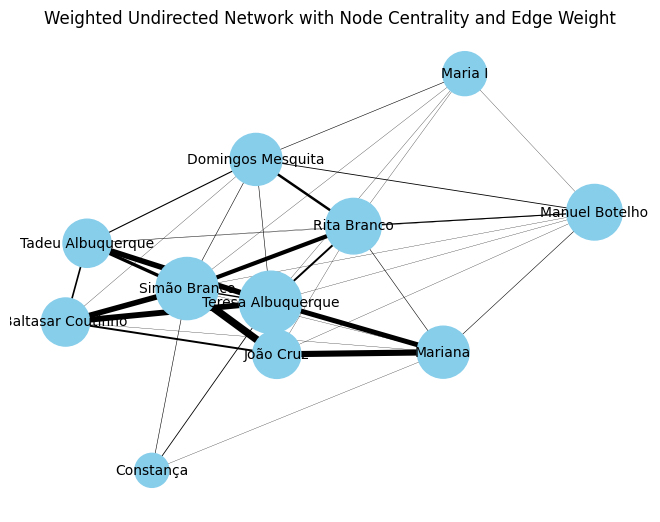

In [53]:
df = interactions_df
# Create an empty graph
G = nx.Graph()

# Add nodes and weighted edges to the graph
for index, row in df.iterrows():
    group1 = row["Character 1"]
    group2 = row["Character 2"]
    count = row["Count"]
    G.add_edge(group1, group2, weight=count)

# Remove nodes with degree less than 3
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < 3]
G.remove_nodes_from(nodes_to_remove)

# Calculate centrality measures for nodes
centrality = nx.degree_centrality(G)

# Draw the network graph
pos = nx.spring_layout(G)  # Positions of nodes

# Draw nodes with size proportional to centrality
node_size = [centrality[node] * 2000 for node in G.nodes()]

# Draw edges with thickness proportional to weight
edge_width = [d["weight"] / 5 for u, v, d in G.edges(data=True)]

nx.draw(G, pos, with_labels=True, node_size=node_size, node_color="skyblue", font_size=10, width=edge_width)
plt.title("Weighted Undirected Network with Node Centrality and Edge Weight")
plt.show()

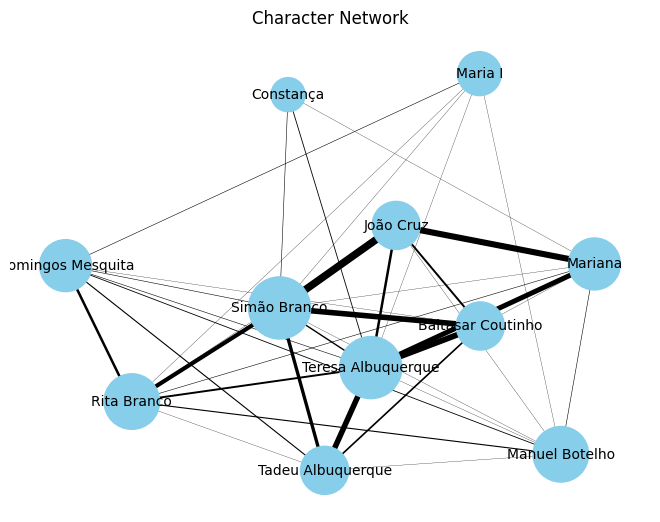

In [54]:
#Draw spring
pos = nx.spring_layout(G, k=4)  # k = distância
# Draw nodes with size proportional to centrality
node_size = [centrality[node] * 2000 for node in G.nodes()]

# Draw edges with thickness proportional to weight
edge_width = [d["weight"] / 5 for u, v, d in G.edges(data=True)]

nx.draw(G, pos, with_labels=True, node_size=node_size, node_color="skyblue", font_size=10, width=edge_width)
plt.title("Character Network")
plt.show()

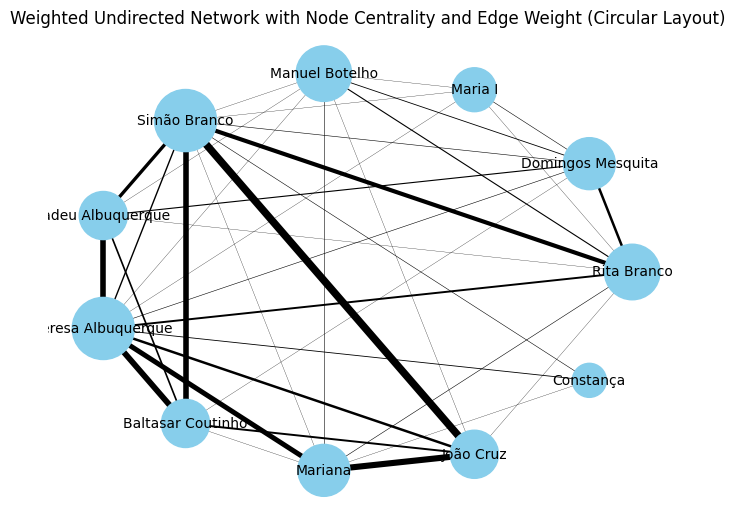

In [55]:
# Draw the network graph with circular layout
pos = nx.circular_layout(G)

# Draw nodes with size proportional to centrality
node_size = [centrality[node] * 2000 for node in G.nodes()]

# Draw edges with thickness proportional to weight
edge_width = [d["weight"] / 5 for u, v, d in G.edges(data=True)]

nx.draw(G, pos, with_labels=True, node_size=node_size, node_color="skyblue", font_size=10, width=edge_width)
plt.title("Weighted Undirected Network with Node Centrality and Edge Weight (Circular Layout)")
plt.show()